# Image Text Translation

In [23]:
import boto3
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

# Initialize AWS clients
textract_client = boto3.client('textract')
translate_client = boto3.client('translate')

In [24]:
def detect_text(image_path):
    """Detects text in the image using Amazon Textract."""
    with open(image_path, 'rb') as document:
        image_bytes = document.read()

    response = textract_client.detect_document_text(Document={'Bytes': image_bytes})

    blocks = response['Blocks']
    
    txt_bb = []
    for block in blocks:
        if block['BlockType'] == 'LINE':
            txt_bb.append({
                "text": block['Text'],
                "bounding_box": block['Geometry']['BoundingBox']
            })
    return txt_bb


In [25]:
def translate_text(text, target_language='en'):
    """Translates text using Amazon Translate."""
    response = translate_client.translate_text(Text=text, SourceLanguageCode="auto", TargetLanguageCode=target_language)
    return response['TranslatedText']


In [26]:
def replace_text_in_image(image_path, text_bounding_box):
    """Replaces text in the image with translated text."""
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    
    # Calculate the dimensions of the bounding box on the image
    width, height = image.size
    
    for t in text_bounding_box:
        translated_text = t["translated_text"]
        bounding_box = t["bounding_box"]
        
        left = bounding_box['Left'] * width
        top = bounding_box['Top'] * height
        box_width = bounding_box['Width'] * width
        box_height = bounding_box['Height'] * height
    
        # Create a white rectangle over the original text area
        draw.rectangle([left, top, left + box_width, top + box_height], fill="white")

        # Load a font (you can specify a different path to a TTF font)
        font = ImageFont.load_default()

        # Replace text
        draw.text((left, top), translated_text, fill="black", font=font)
    
    # Display the modified image inline in the notebook
    display(image)
    
    # Save the modified image
    image.save('translated_image.png')
    print("Text replaced and image saved as 'translated_image.png'")


Before Translation:



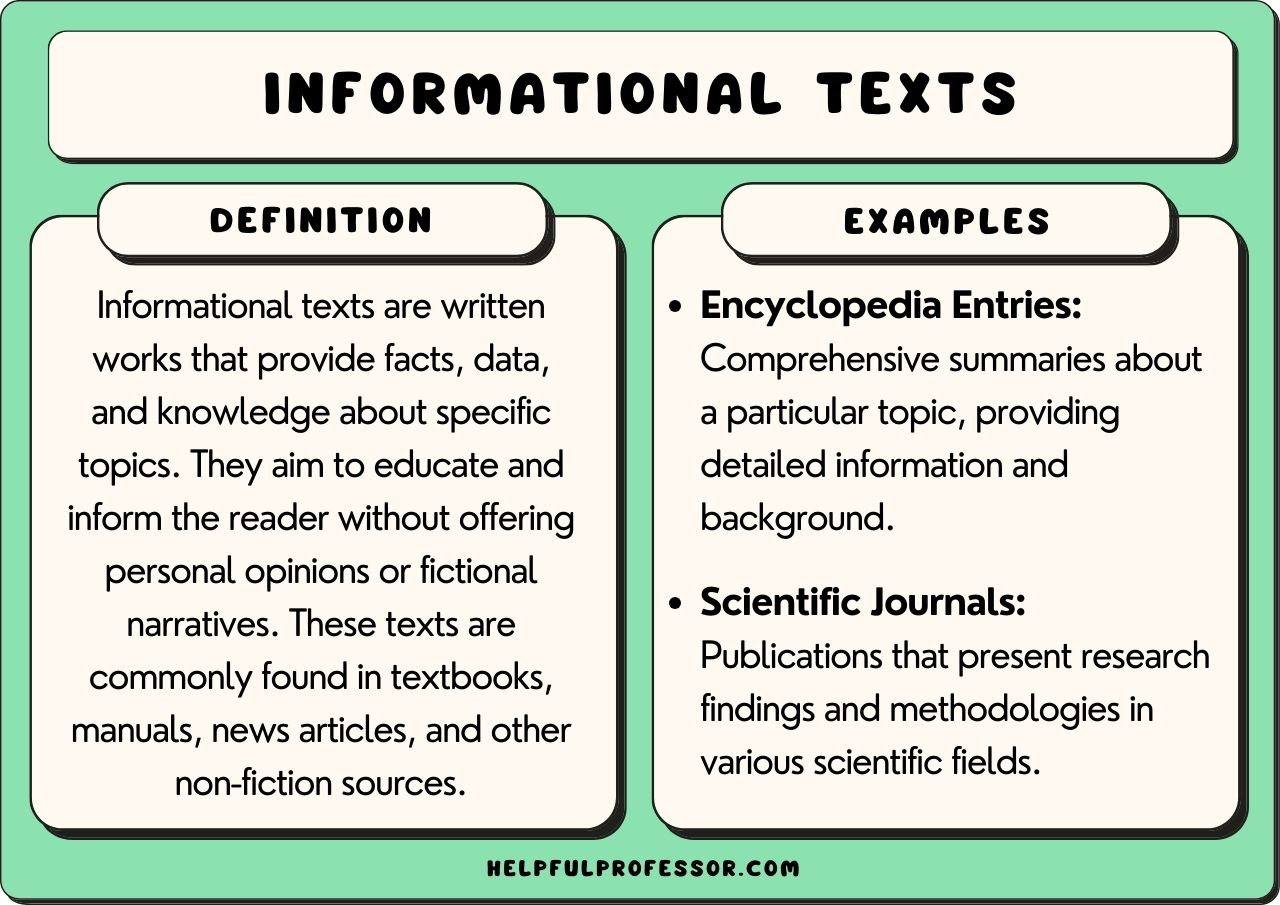

After Translation:



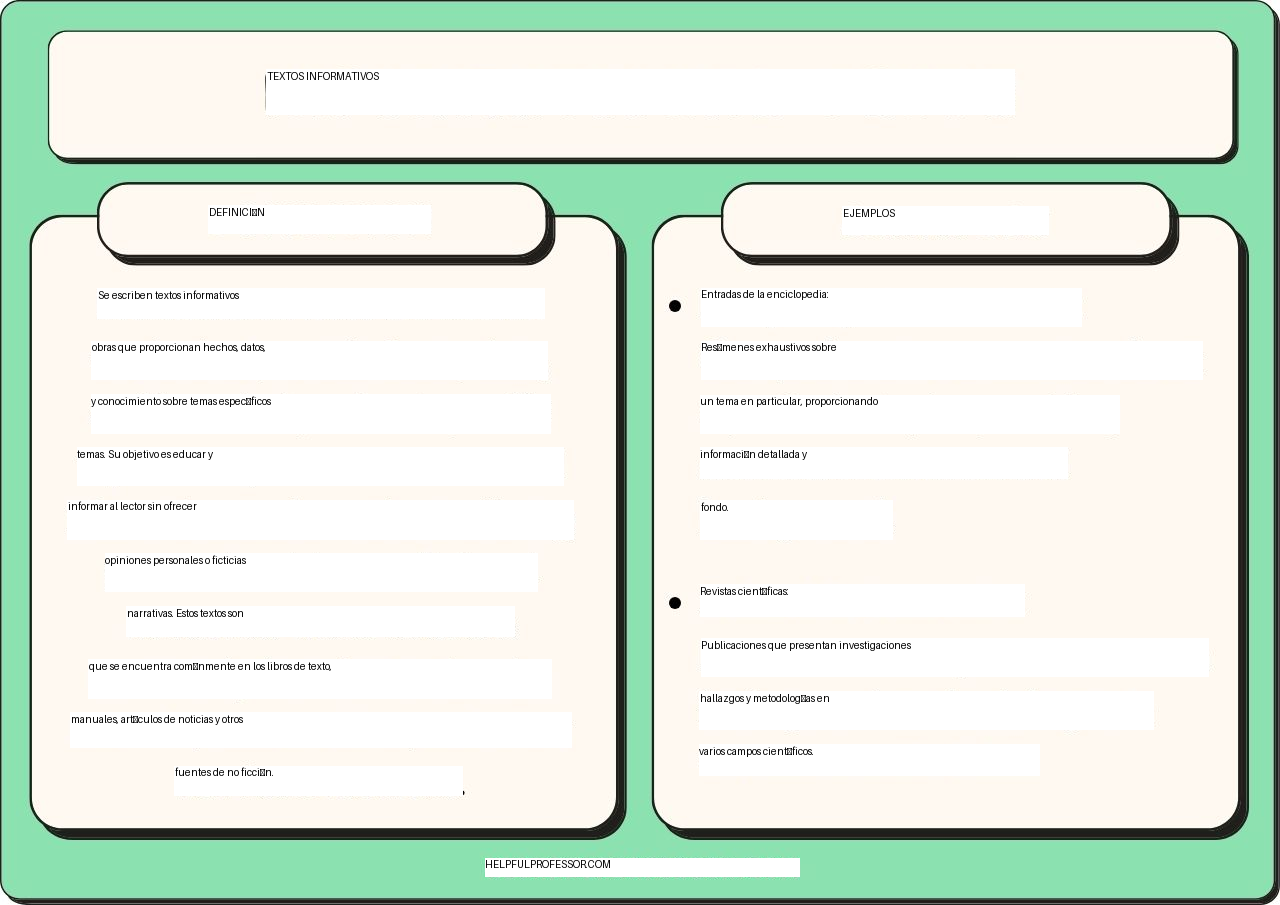

Text replaced and image saved as 'translated_image.png'


In [29]:
def main(image_path, target_language='en'):
    # Step 1: Detect text in the image
    text_bounding_box = detect_text(image_path)

    # Step 2: Translate the detected text
    for i, t in enumerate(text_bounding_box):
        translated_text = translate_text(t["text"], target_language=target_language)
        text_bounding_box[i]["translated_text"] = translated_text

    # Step 3: Replace the text in the image
    replace_text_in_image(image_path, text_bounding_box)

# Specify the path to your image and the target language
image_path = 'image.png'  # Path to your input image
target_language = 'es'  # Target language code (e.g., 'es' for Spanish)

# Run the main function
print("Before Translation:\n")
display(Image.open(image_path))
print("After Translation:\n")
main(image_path, target_language)